In [4]:
from re import L
from sklearn import metrics
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pprint as pp
import tarfile
import math
import plotly.express as px

from bertviz import model_view, head_view
import torch
from transformers import *
import pprint
from sklearn.decomposition import PCA
import seaborn as sns

### Loading the data 

In [5]:
import pickle
import os
trials=pickle.load(open("data/trials.bin","rb"))
docs_brief_title = pickle.load( open( "data/docs_brief_title.bin", "rb" ) )
ids_brief_title = pickle.load( open( "data/doc_ids.bin", "rb" ) )
docs_detailed_description=pickle.load( open( "data/docs_detailed_description.bin", "rb" ) )
docs_brief_summary=pickle.load( open( "data/docs_brief_summary.bin", "rb" ) )
docs_criteria=pickle.load( open( "data/docs_criteria.bin", "rb" ) )
ids_detailed_description=pickle.load( open( "data/doc_ids_description.bin", "rb" ) )
ids_brief_summary=pickle.load( open( "data/doc_ids_summary.bin", "rb" ) )
ids_criteria=pickle.load( open( "data/doc_ids_criteria.bin", "rb" ) )

### Checking if each dict has the same length

In [6]:
# # print(len(docs_brief_summary),type(docs_brief_summary))
# # print(len(docs_brief_title),type(docs_brief_title))
# # print(len(docs_detailed_description),type(docs_detailed_description))
# # print(len(docs_criteria),type(docs_criteria))
dict_detailed=docs_detailed_description
docs_brief_summary=list(docs_brief_summary.values())
docs_brief_title=list(docs_brief_title.values())
docs_detailed_description=list(docs_detailed_description.values())
docs_criteria=list(docs_criteria.values())
print(len(docs_brief_summary),type(docs_brief_summary))
print(len(docs_brief_title),type(docs_brief_title))
print(len(docs_detailed_description),type(docs_detailed_description))
print(len(docs_criteria),type(docs_criteria))
print(len(trials),type(trials))
for x in range(len(docs_brief_summary)):
    y=len(docs_brief_summary[x])
    if y<1:
        print(x,"brief_sum")
    y=len(docs_brief_title[x])
    if y<1:
        print(x,"brief_title")
    y=len(docs_detailed_description[x])
    if y<1:
        print(x,"descr")
    y=len(docs_criteria[x])
    if y<1:
        print(x,"crit")
    





3626 <class 'list'>
3626 <class 'list'>
3626 <class 'list'>
3626 <class 'list'>
3870 <class 'pandas.core.frame.DataFrame'>


### Loading the queries 

In [7]:
Queries = "data/topics-2014_2015-summary.topics"
with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()
root = ET.fromstring(txt)
cases = {}
for q in root.iter('TOP'):
    q_number = q.find("NUM").text
    q_title = q.find('TITLE').text
    cases[q_number] = q_title

# Input formatting and Tokenization

##  Select (1) a query, (2) a relevant document and (3) a non-relevant document. Use only the detailed description field.


In [8]:
q1=cases["20141"]
q2=cases["201414"]
q3=cases["201421"]
d1=dict_detailed["NCT00175279"]
d2=dict_detailed["NCT00928941"]
d3=dict_detailed["NCT00166231"]
d4=dict_detailed["NCT01075035"]
d5=dict_detailed["NCT00965809"]
d6=dict_detailed["NCT00982670"]
anr=[q1,d1]
ar=[q1,d2]
bnr=[q2,d3]
br=[q2,d4]
cnr=[q3,d5]
cr=[q3,d6]
relevant_pairs=[ar,br,cr]
not_relevant_pairs=[anr,bnr,cnr]

## Select a BERT model and load it in your project.

In [9]:
model_path = 'bert-base-uncased'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_path, config=config).to(device)

loading configuration file config.json from cache at /Users/anteklasik/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/anteklasik/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/v

## Format the BERT input according to the next sentence prediction task.

In [10]:
from transformers import BertTokenizer, BertModel
from transformers import *
import pprint
model_path = 'bert-base-uncased'

def token_separator(a,b):
    rel=[]
    nrel=[]
    token_ids_rel=[]
    token_ids_nrel=[]
    for x in range (len(a)):
        inputs=tokenize_encode(a[x][0],a[x][1])
        input_id_list = inputs["input_ids"][0].tolist()
        token_ids_rel.append(input_id_list )
        tokens = tokenizer.convert_ids_to_tokens(input_id_list)
        rel.append(tokens)
        inputs=tokenize_encode(b[x][0],b[x][1])
    
        input_id_list = inputs["input_ids"][0].tolist()
        token_ids_nrel.append(input_id_list )
        tokens = tokenizer.convert_ids_to_tokens(input_id_list)
        nrel.append(tokens)
    return rel,nrel,token_ids_rel,token_ids_nrel

def tokenize_encode(sentence_a,sentence_b):
    inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
    return inputs



## Run the tokenizer and examine how it split the text into tokens.

In [11]:
rel_tokens,nrel_tokens,rel_token_ids,nrel_token_ids=token_separator(relevant_pairs,not_relevant_pairs)
for x in range (len(rel_tokens)):
    print("rel pair")
    print(rel_tokens[x])
    print(rel_token_ids[x])
    print("_______________________")
    print("non-rel pair")
    print(nrel_tokens[x])
    print(nrel_token_ids[x])
    print("_______________________")


rel pair
['[CLS]', '58', '-', 'year', '-', 'old', 'woman', 'with', 'hyper', '##tension', 'and', 'obesity', 'presents', 'with', 'exercise', '-', 'related', 'ep', '##iso', '##dic', 'chest', 'pain', 'radiating', 'to', 'the', 'back', '.', '[SEP]', '1', '.', 'objective', '(', 's', ')', 'post', 'traumatic', 'stress', 'disorder', '(', 'pts', '##d', ')', 'has', 'been', 'established', 'as', 'relatively', 'common', 'in', 'a', 'significant', 'number', 'of', 'o', '##ef', '/', 'o', '##if', 'veterans', '(', 'vast', '##er', '##ling', '&', 'bra', '##ile', '##y', ',', '2005', ';', 'hog', '##e', 'et', 'al', '.', ',', '2008', ')', '.', 'attention', 'deficit', '##s', ',', 'which', 'are', 'prominent', 'in', 'pts', '##d', ',', 'may', 'be', 'due', 'to', 'difficulty', 'sustaining', 'attention', 'over', 'time', 'and', 'encoding', 'or', 'getting', 'information', 'into', 'storage', 'which', 'leads', 'to', 'reduced', 'attention', 'and', 'memory', 'scores', 'on', 'ne', '##uro', '##psy', '##cho', '##logical', 'meas

# Layer embeddings visualization

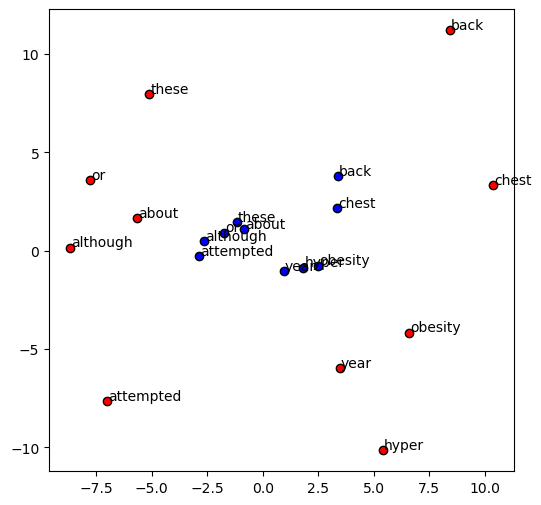

In [12]:
inputs=tokenizer.encode_plus(q1, d1, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
words=np.array(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist()))
first=[]
last=[]
l=[3,8,11,20,25,30,35,60,84,95]
secik=words[l]

with torch.no_grad():
    outputs = model(**inputs)

hidden_states = outputs['hidden_states']
first_layer=np.array(hidden_states[1][0][l])
last_layer=np.array(hidden_states[-1][0][l])
pca = PCA(n_components=2)
first_layer_pca=pca.fit_transform(first_layer)
last_layer_pca =pca.transform(last_layer)
plt.figure(figsize=(6,6))
plt.scatter(first_layer_pca[:, 0], first_layer_pca[:, 1],edgecolors='k', c='r')
plt.scatter(last_layer_pca[:, 0], last_layer_pca[:, 1],edgecolors='k', c='b')
for word, (x,y) in zip(secik,first_layer_pca):
    plt.text(x+0.05, y+0.05, word)
for word, (x,y) in zip(secik,last_layer_pca):
    plt.text(x+0.05, y+0.05, word)
plt.show()

# Layer embeddings similarity visualization

# Non-relevant pair 

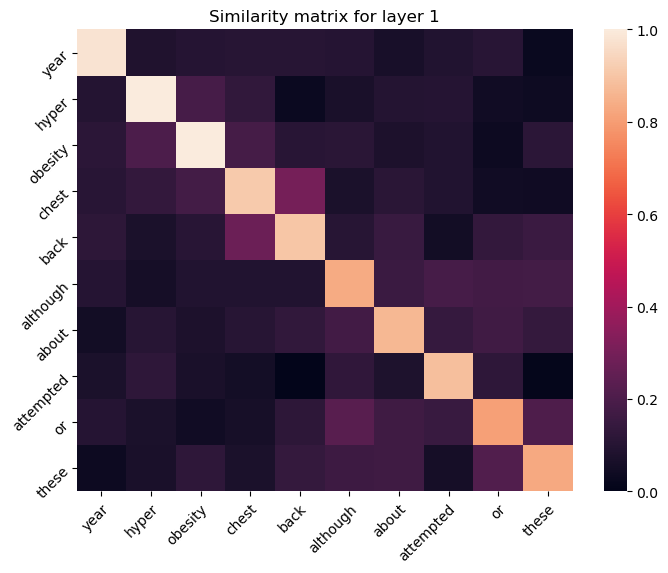

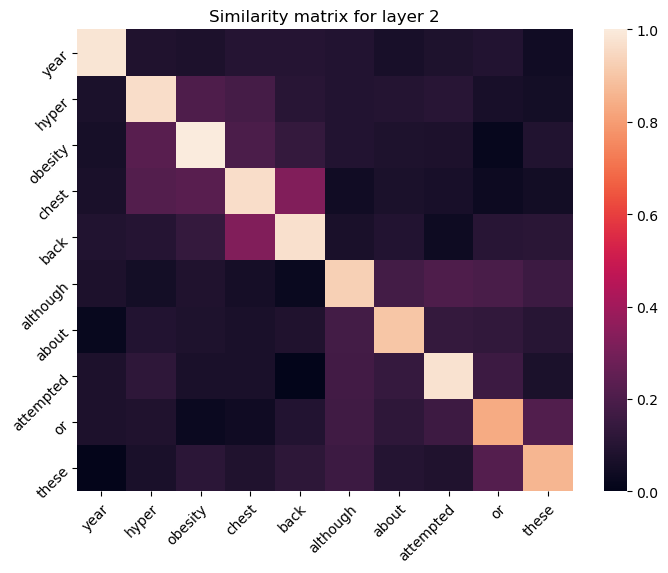

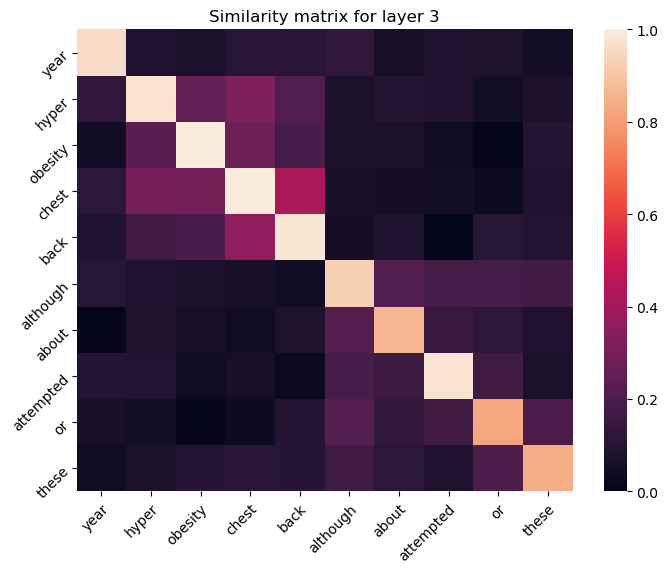

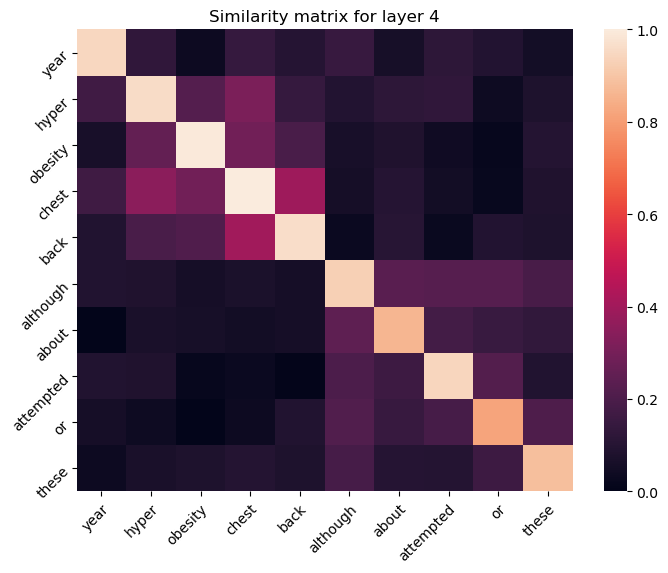

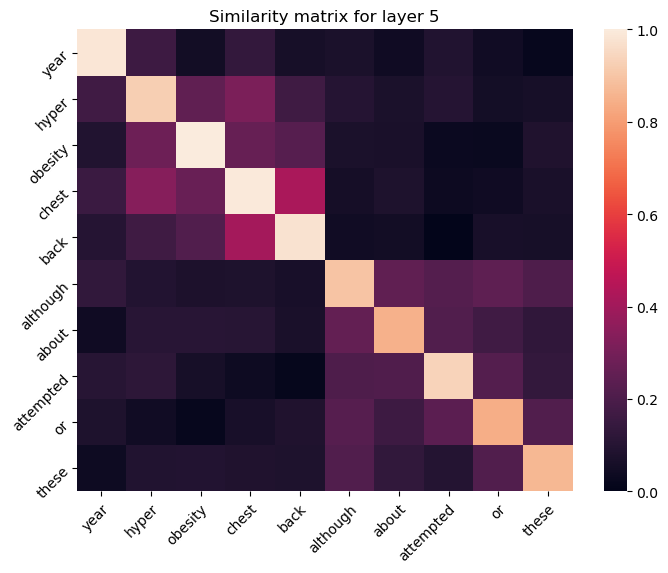

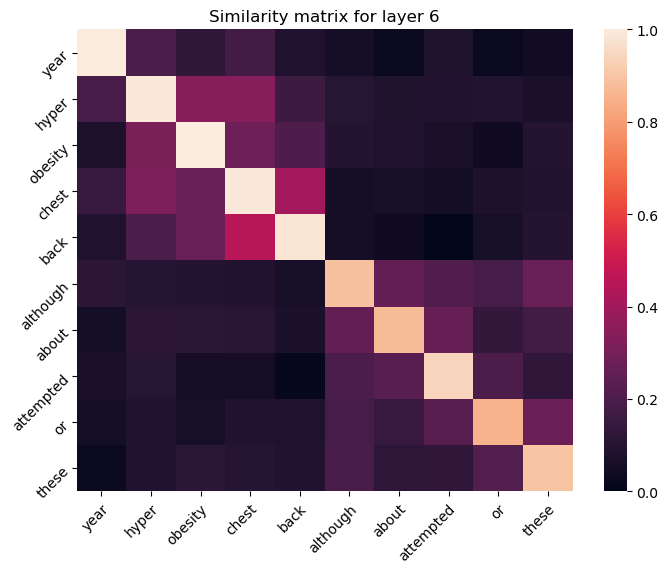

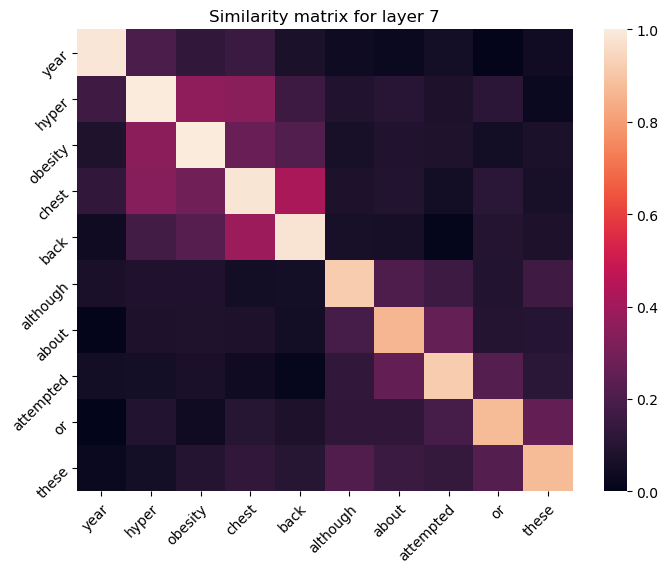

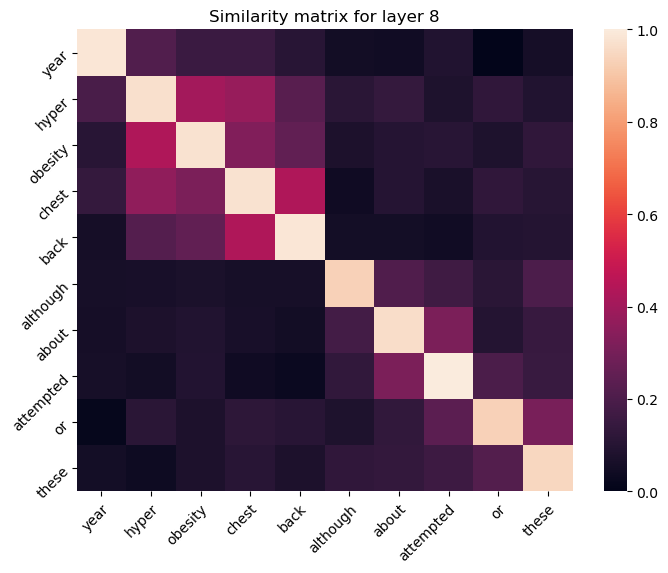

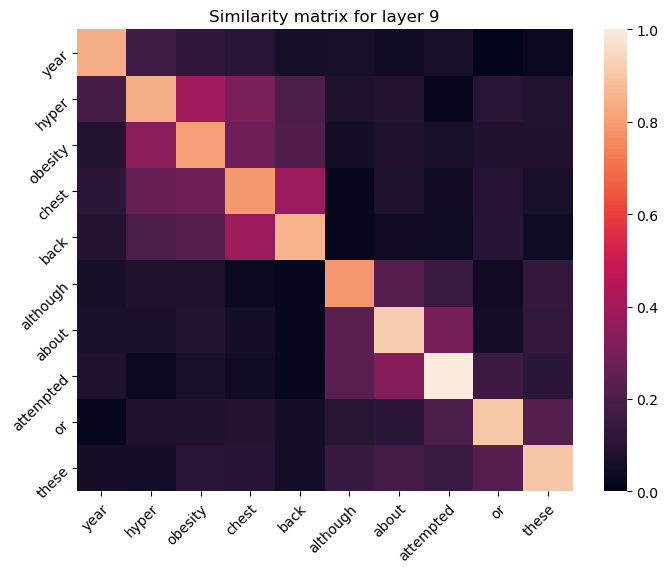

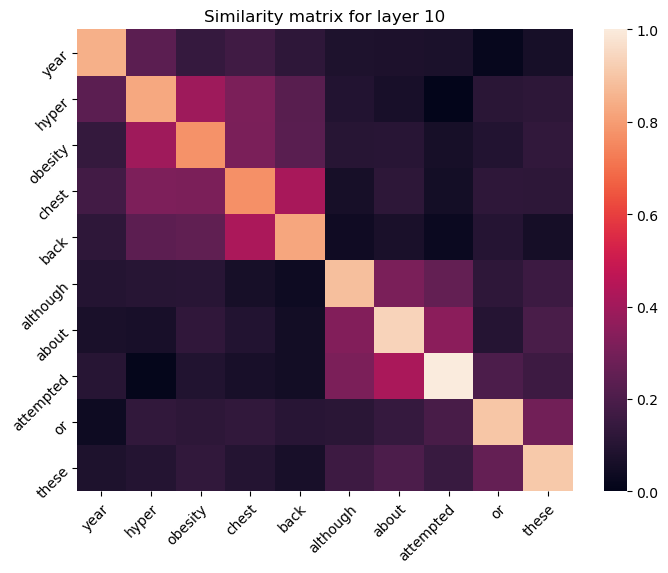

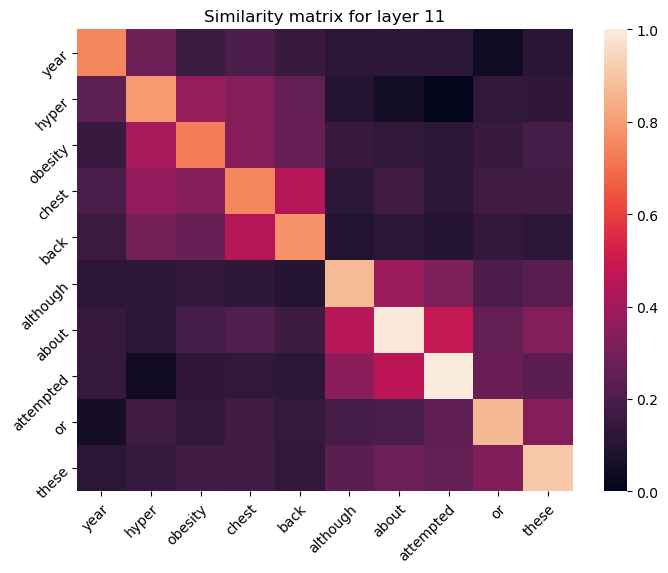

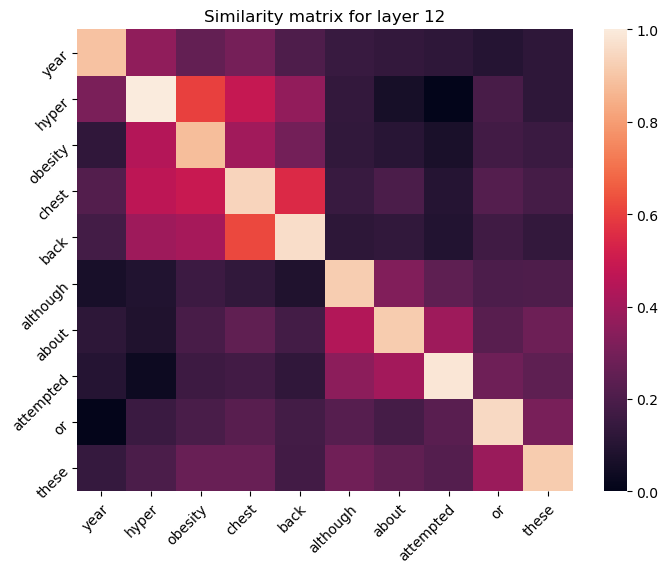

In [13]:
#for layer similarity visualisation
inputs=tokenizer.encode_plus(q1, d1, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
words=np.array(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist()))
l=[3,8,11,20,25,30,35,60,84,95]
for i in range (0,12):
    hidden_states = outputs['hidden_states']
    layer_input=np.array(hidden_states[i][0][l])
    layer_output=np.array(hidden_states[i+1][0][l])
    similarity = np.inner(layer_input, layer_output)
    similarity=(similarity-np.min(similarity))/(np.max(similarity)-np.min(similarity))
    plt.figure(figsize=(8,6))
    ax= plt.subplot()
    sns.heatmap(similarity, fmt='g', ax=ax)
    ax.xaxis.set_ticklabels(words[l])
    ax.yaxis.set_ticklabels(words[l])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_title("Similarity matrix for layer %d" % (i+1))

# plt.imshow(similarity, cmap='binary')

# plt.xticks(10, words[:10])
# plt.yticks(10, words[:10])
# plt.colorbar()


# Relevant pair


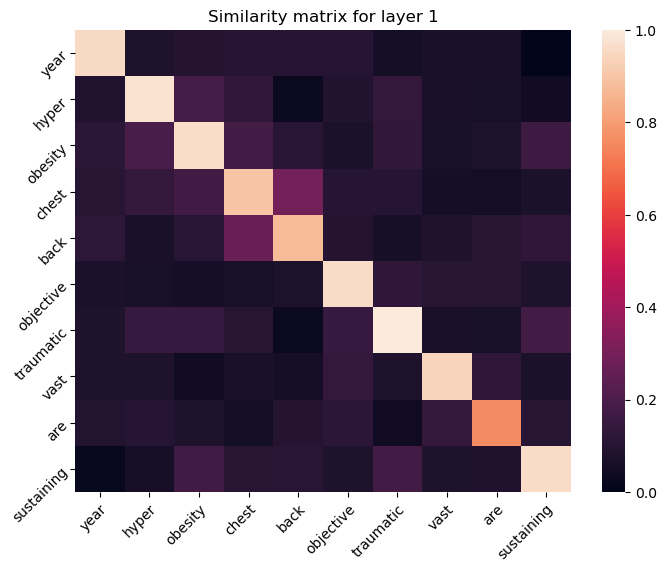

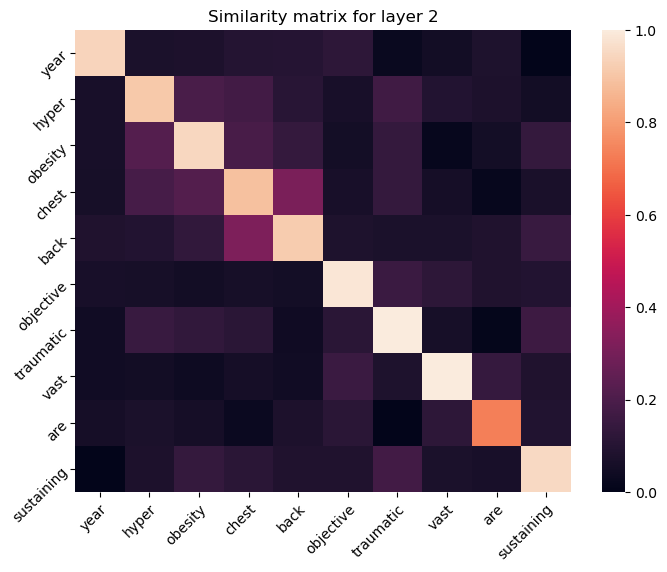

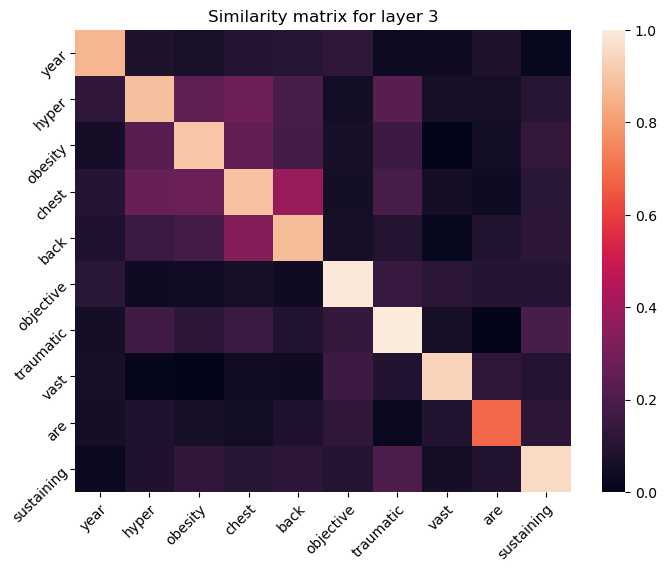

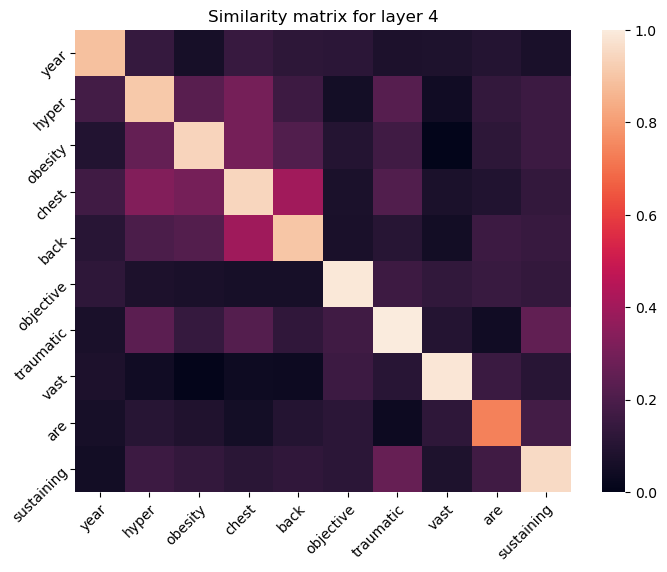

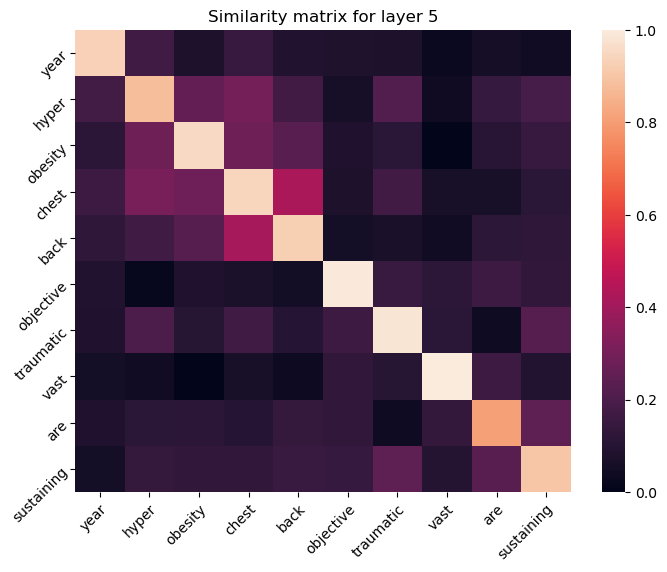

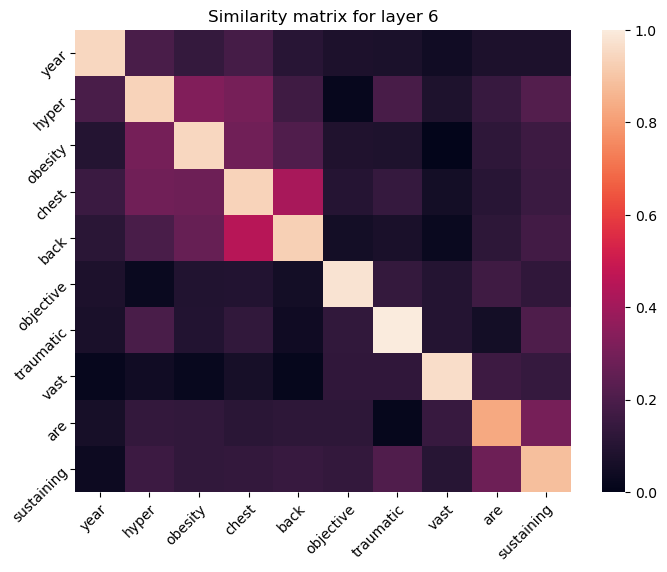

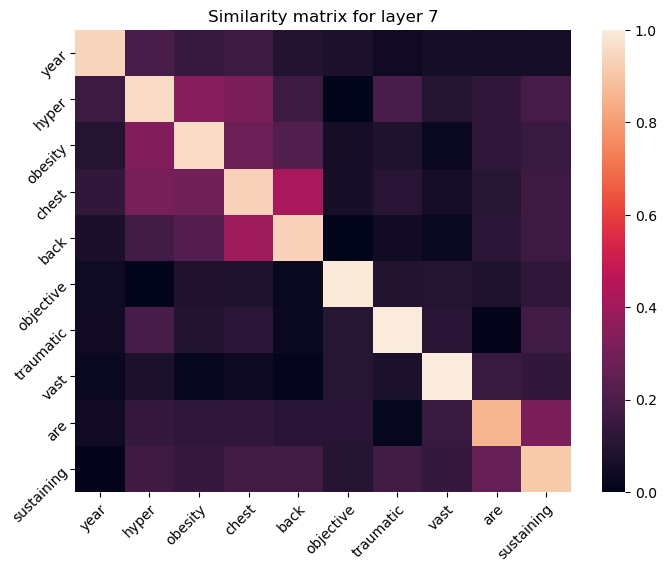

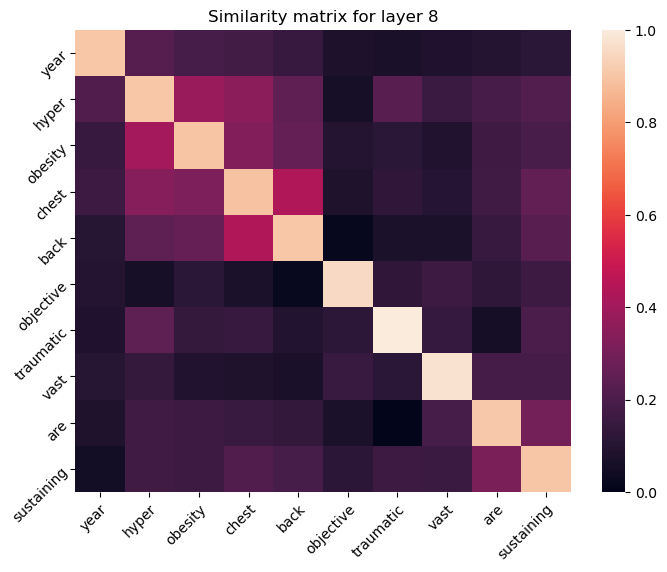

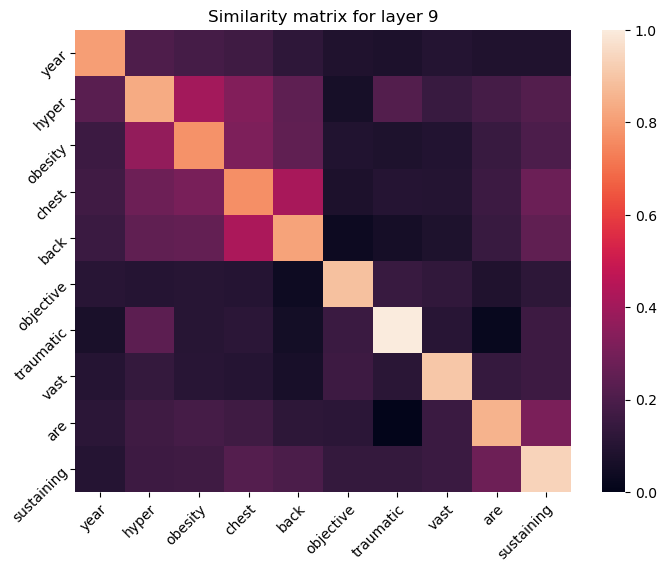

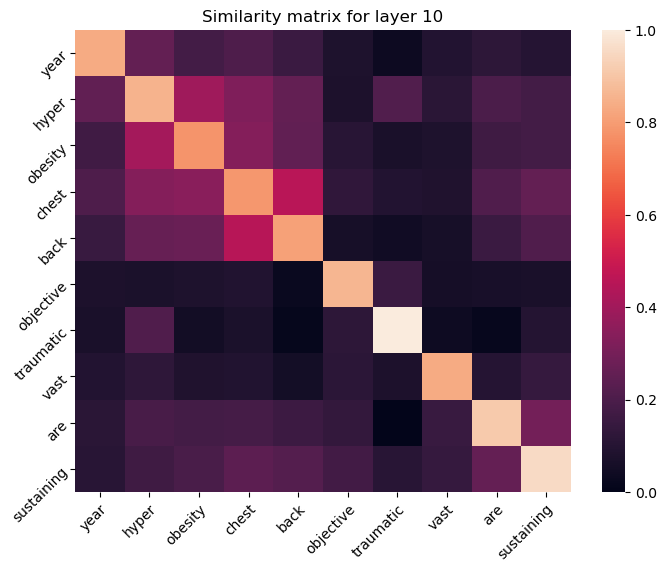

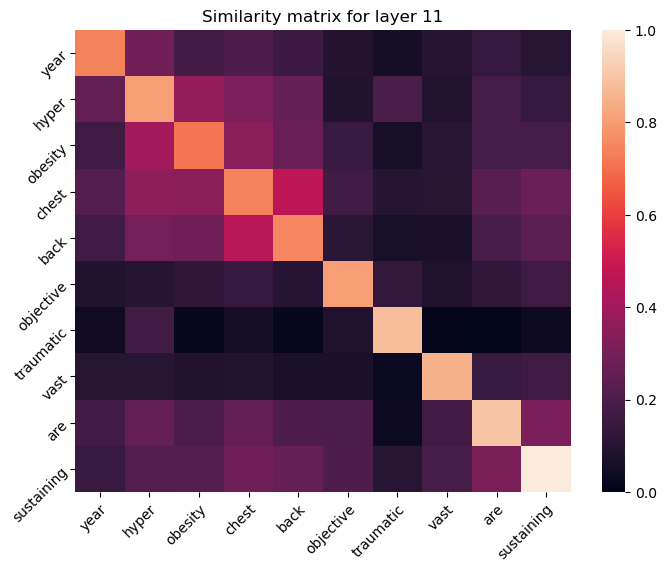

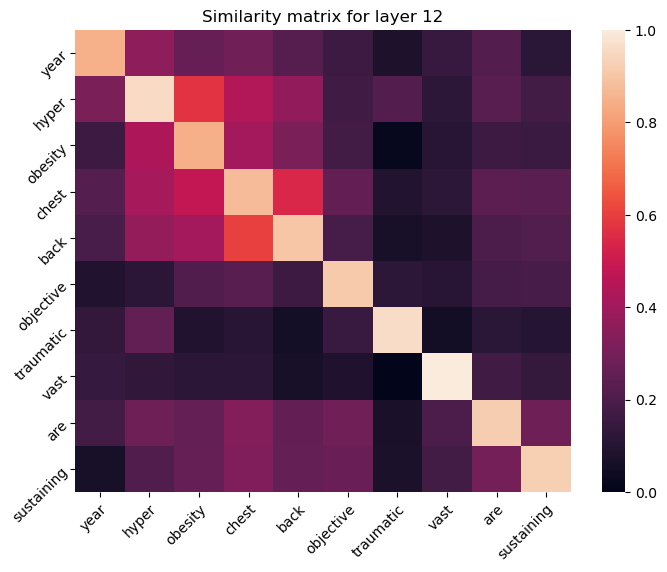

In [20]:
inputs=tokenizer.encode_plus(q1, d2, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
words=np.array(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist()))
l=[3,8,11,20,25,30,35,60,84,95]
with torch.no_grad():
    outputs = model(**inputs)
for i in range (0,12):
    hidden_states = outputs['hidden_states']
    layer_input=np.array(hidden_states[i][0][l])
    layer_output=np.array(hidden_states[i+1][0][l])
    similarity = np.inner(layer_input, layer_output)
    similarity=(similarity-np.min(similarity))/(np.max(similarity)-np.min(similarity))
    plt.figure(figsize=(8,6))
    ax= plt.subplot()
    sns.heatmap(similarity, fmt='g', ax=ax)
    ax.xaxis.set_ticklabels(words[l])
    ax.yaxis.set_ticklabels(words[l])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_title("Similarity matrix for layer %d" % (i+1))

## Non relevant pair num.2 

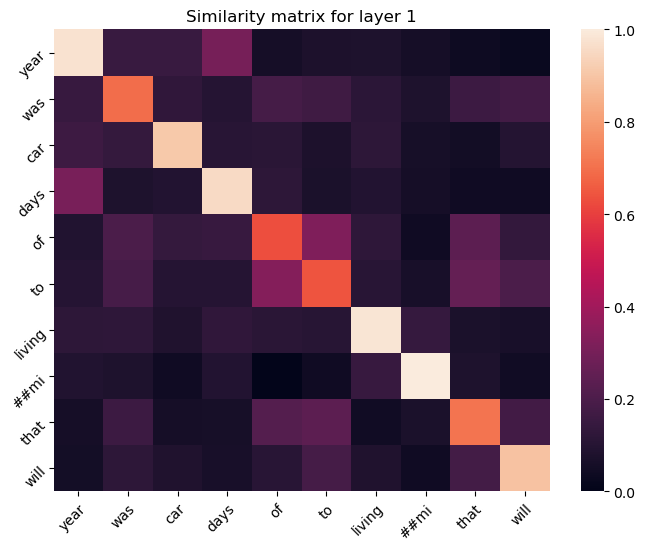

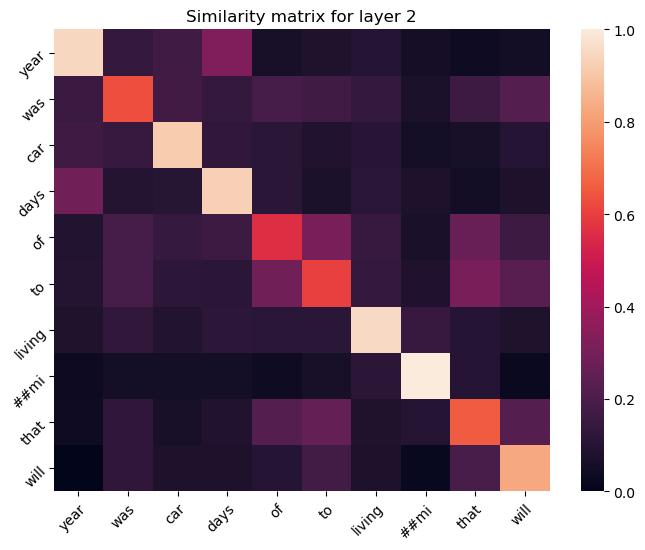

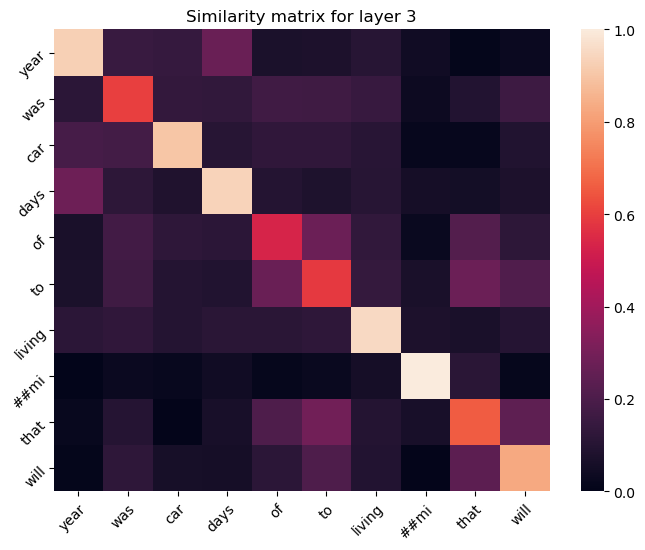

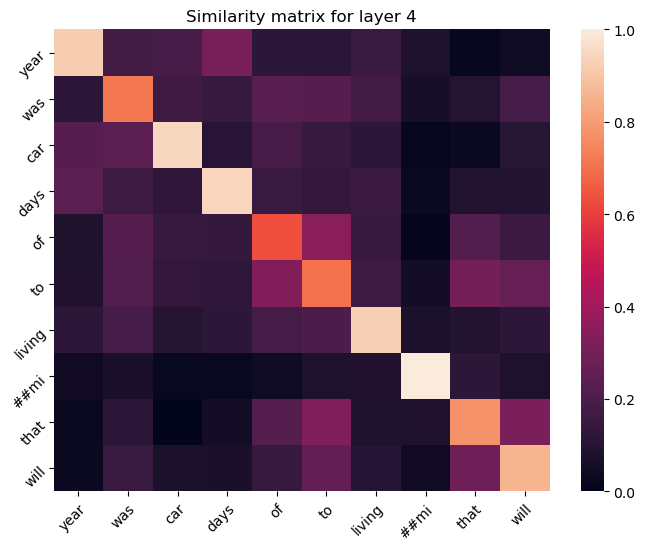

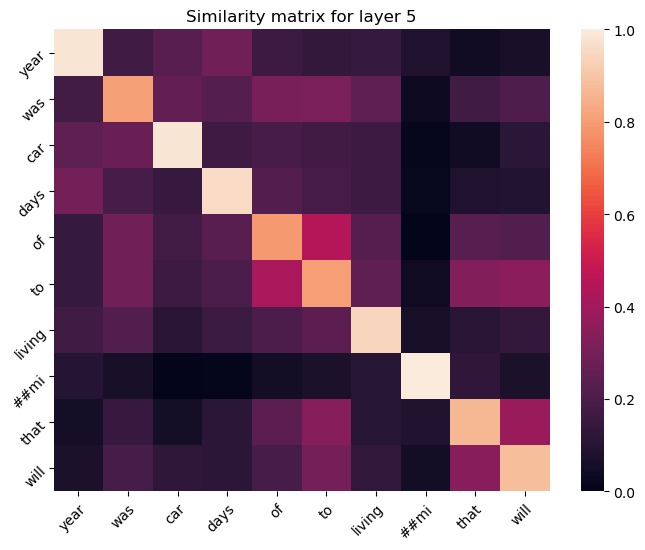

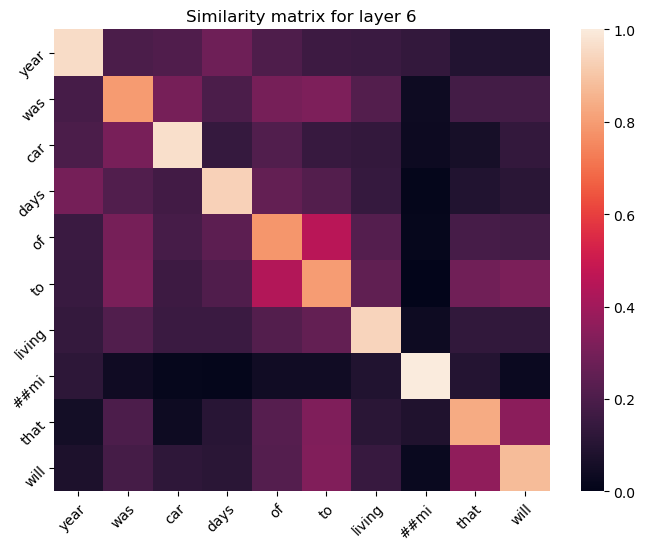

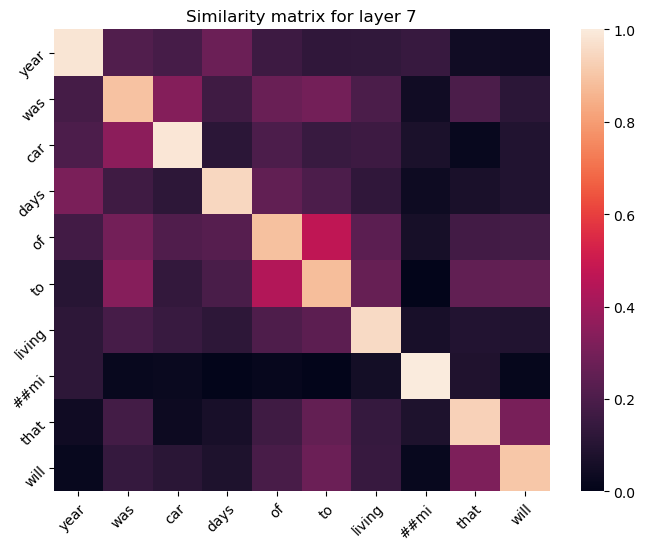

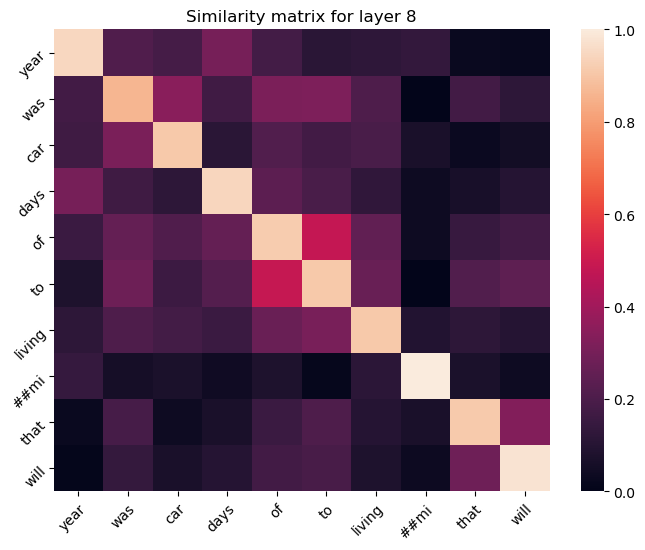

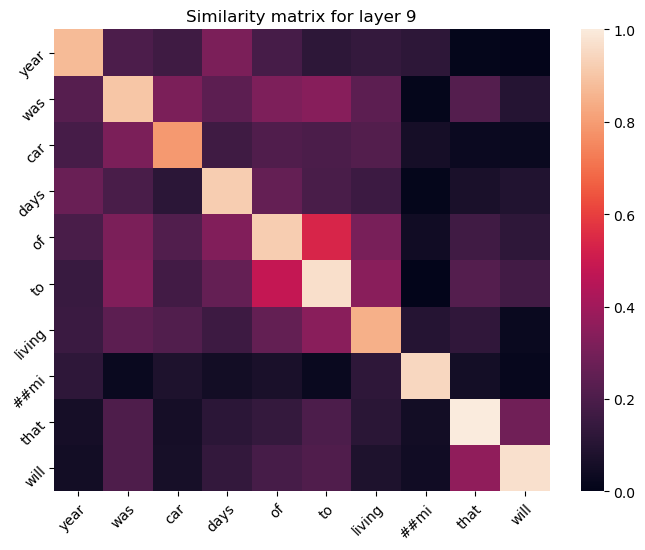

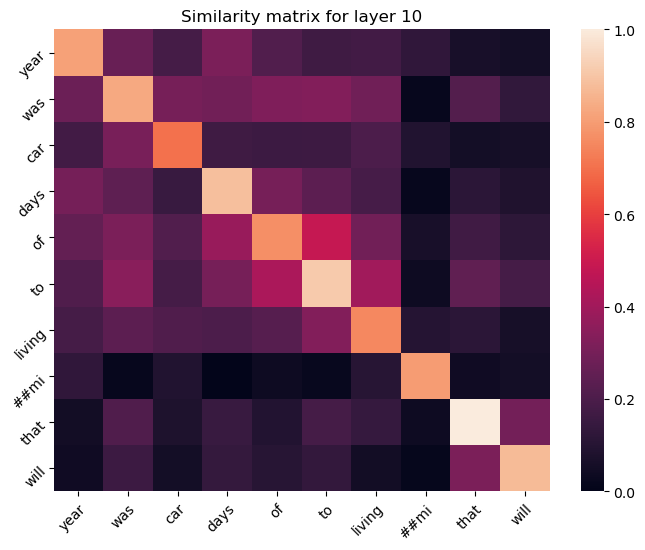

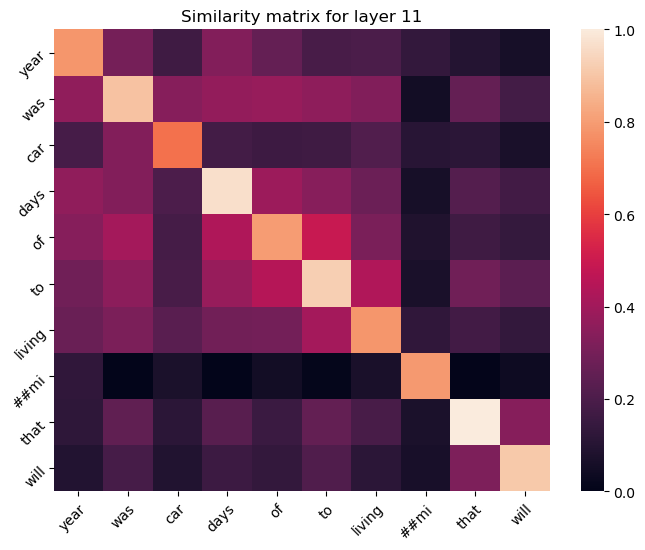

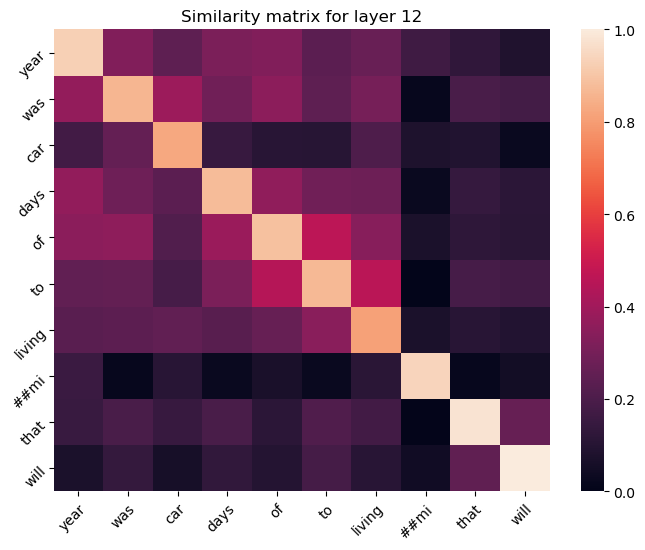

In [15]:
inputs=tokenizer.encode_plus(q2, d3, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
words=np.array(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist()))
l=[3,8,11,20,25,30,35,62,84,95]
with torch.no_grad():
    outputs = model(**inputs)
for i in range (0,12):
    hidden_states = outputs['hidden_states']
    layer_input=np.array(hidden_states[i][0][l])
    layer_output=np.array(hidden_states[i+1][0][l])
    similarity = np.inner(layer_input, layer_output)
    similarity=(similarity-np.min(similarity))/(np.max(similarity)-np.min(similarity))
    plt.figure(figsize=(8,6))
    ax= plt.subplot()
    sns.heatmap(similarity, fmt='g', ax=ax)
    ax.xaxis.set_ticklabels(words[l])
    ax.yaxis.set_ticklabels(words[l])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_title("Similarity matrix for layer %d" % (i+1))

## Relevant pair numb.2

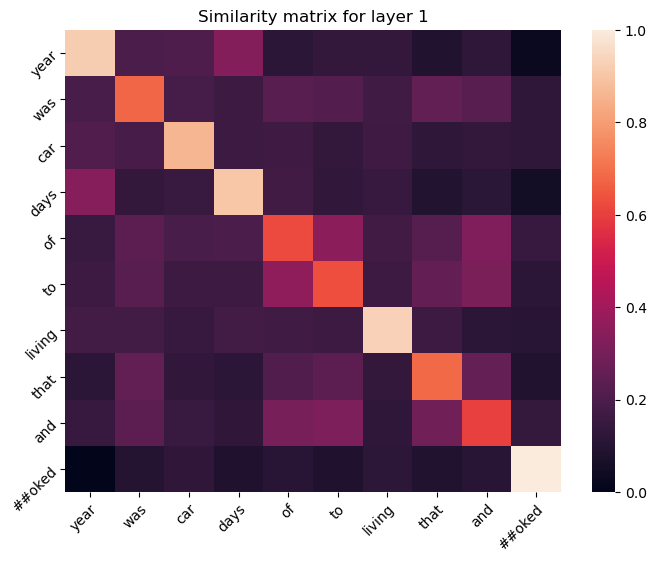

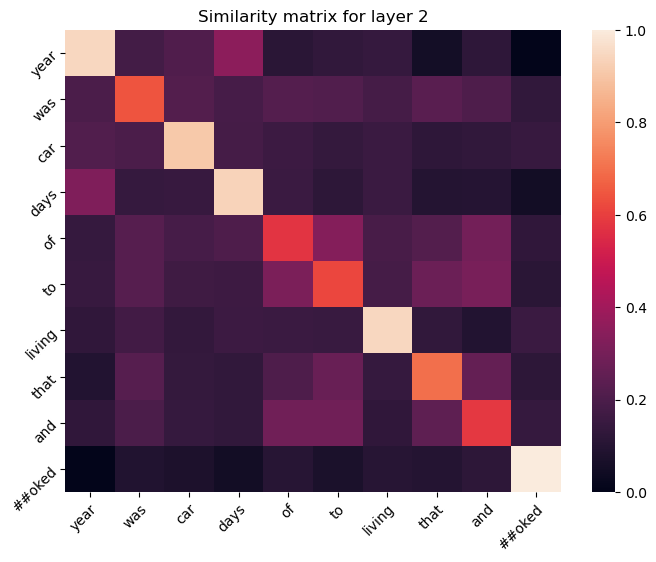

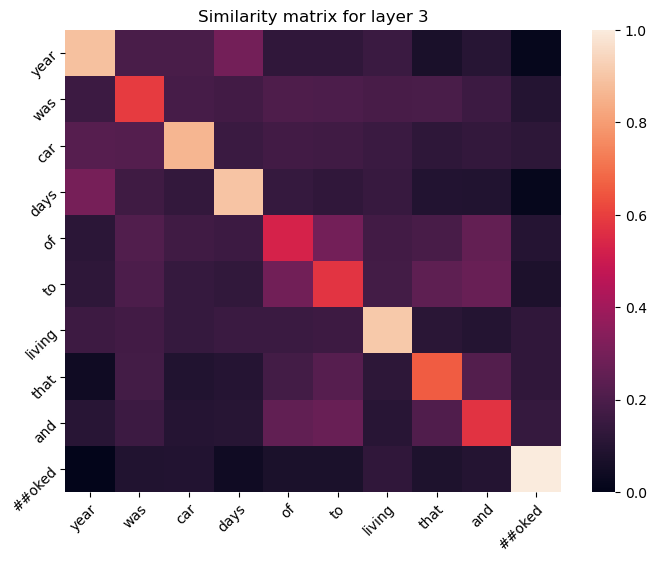

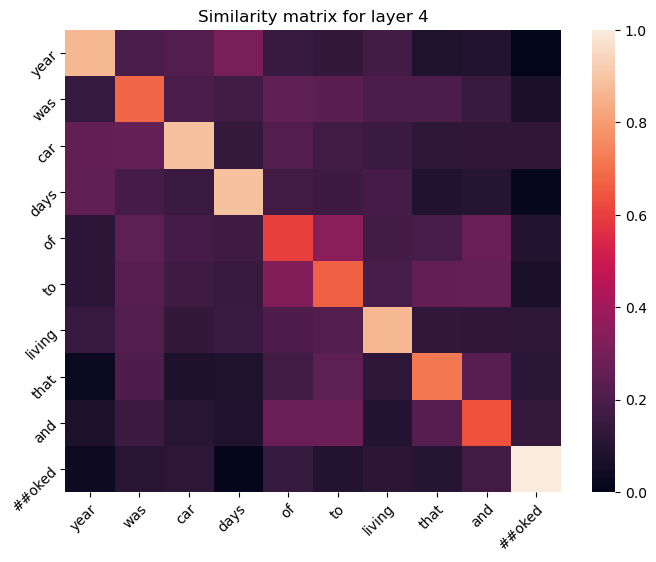

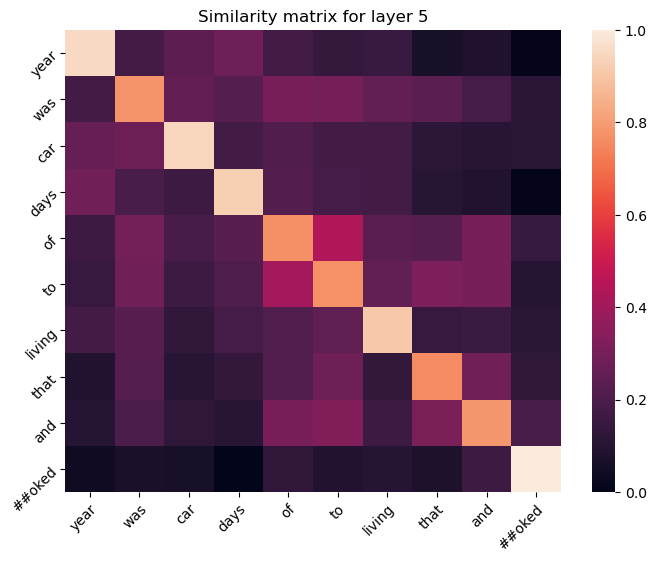

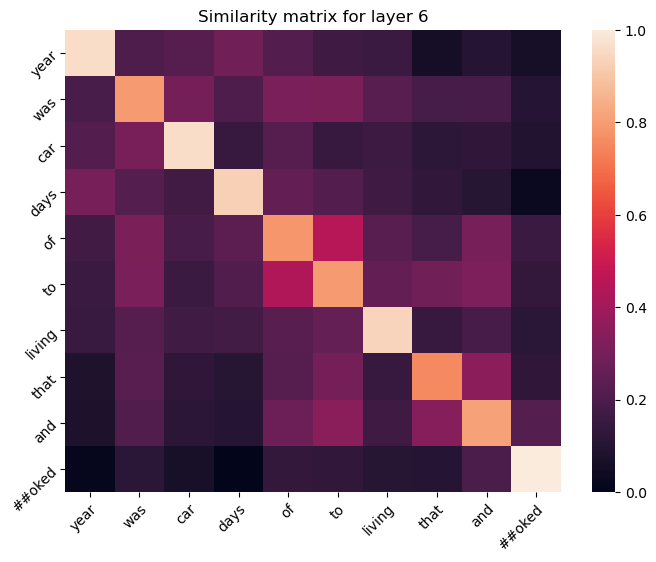

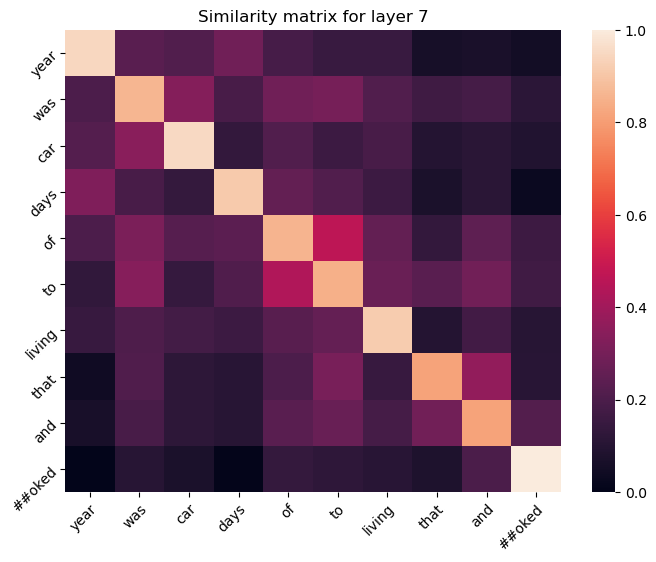

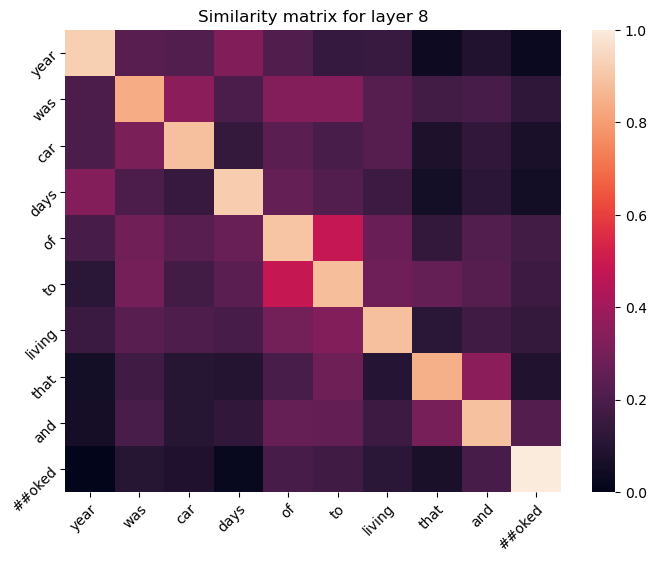

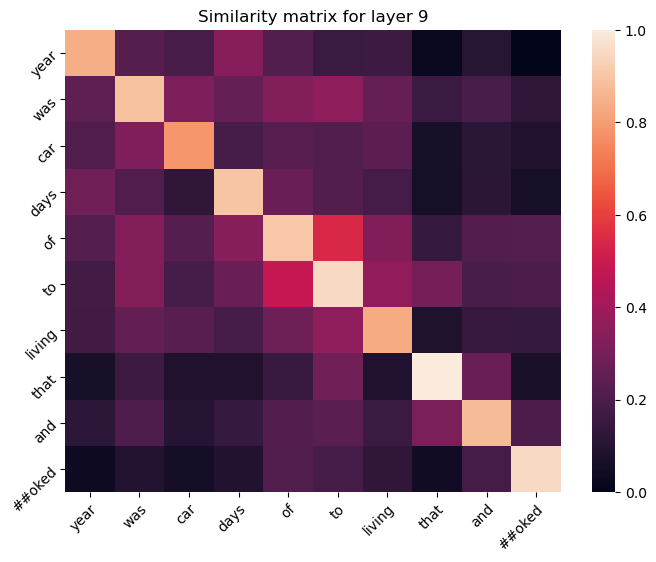

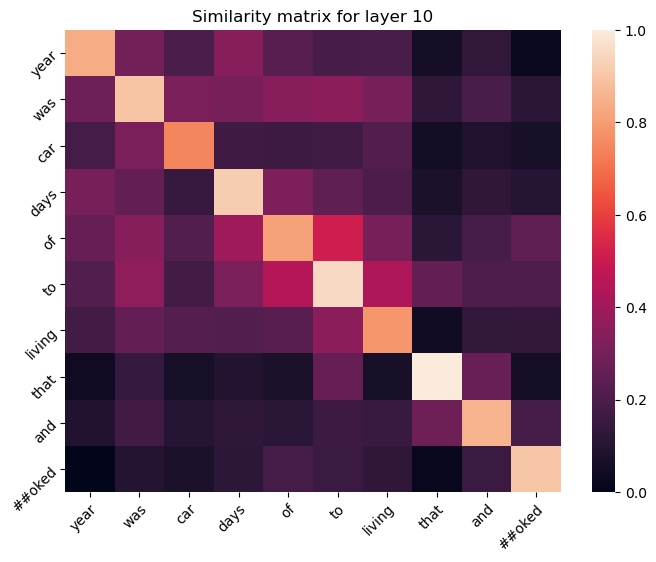

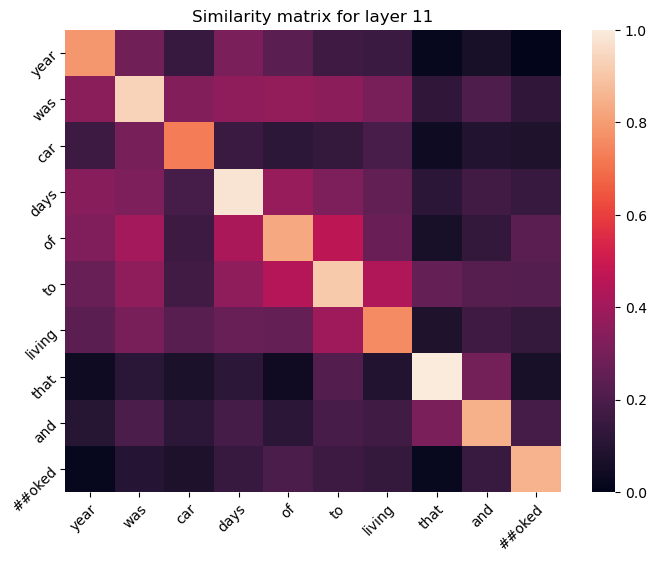

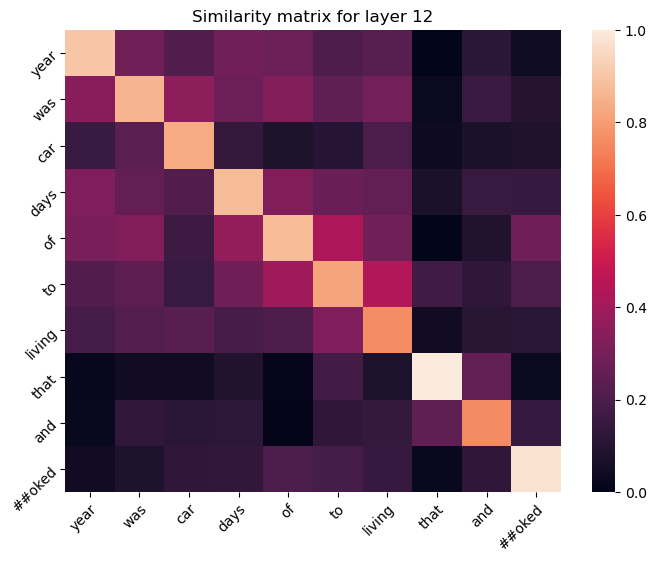

In [21]:
inputs=tokenizer.encode_plus(q2, d4, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
words=np.array(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist()))
l=[3,8,11,20,25,30,35,62,84,95]
with torch.no_grad():
    outputs = model(**inputs)
for i in range (0,12):
    hidden_states = outputs['hidden_states']
    layer_input=np.array(hidden_states[i][0][l])
    layer_output=np.array(hidden_states[i+1][0][l])
    similarity = np.inner(layer_input, layer_output)
    similarity=(similarity-np.min(similarity))/(np.max(similarity)-np.min(similarity))
    plt.figure(figsize=(8,6))
    ax= plt.subplot()
    sns.heatmap(similarity, fmt='g', ax=ax)
    ax.xaxis.set_ticklabels(words[l])
    ax.yaxis.set_ticklabels(words[l])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_title("Similarity matrix for layer %d" % (i+1))

# Self-attention head visualization

In [17]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        
        
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        
        '''))

## Non relevant pair

In [33]:
inputs=tokenizer.encode_plus(q1, d1, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
words=np.array(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist()))
l=[3,8,11,20,25,30,35,62,84,95]
with torch.no_grad():
    outputs = model(**inputs)


attention = (torch.Tensor(np.array(outputs['attentions'][0]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][1]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][2]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][3]).take(l, axis = 2).take(l, axis = 3)), 
            torch.Tensor(np.array(outputs['attentions'][4]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][5]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][6]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][7]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][8]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][9]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][10]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][11]).take(l, axis = 2).take(l, axis = 3)))
secik=list(words[l])
call_html()
head_view(attention, secik)



<IPython.core.display.Javascript object>

In [34]:
model_view(attention, secik)


<IPython.core.display.Javascript object>

## Relevant Pair

In [19]:
inputs=tokenizer.encode_plus(q1, d2, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)
words=np.array(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].tolist()))
l=[3,8,11,20,25,30,35,62,84,95]
with torch.no_grad():
    outputs = model(**inputs)


attention = (torch.Tensor(np.array(outputs['attentions'][0]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][1]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][2]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][3]).take(l, axis = 2).take(l, axis = 3)), 
            torch.Tensor(np.array(outputs['attentions'][4]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][5]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][6]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][7]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][8]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][9]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][10]).take(l, axis = 2).take(l, axis = 3)),
            torch.Tensor(np.array(outputs['attentions'][11]).take(l, axis = 2).take(l, axis = 3)))
secik=list(words[l])
call_html()
head_view(attention, secik)

<IPython.core.display.Javascript object>